PyTorch provides the elegantly designed modules and classes:
- `torch.nn`, `torch.optim`, `Dataset`, and `DataLoader` to help you create and train neural networks
- In n order to fully utilize their power and customize them for your problem, you need to really understand exactly what they're doing.

# MNIST data setup

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path('data')
PATH = DATA_PATH/'mnist'

PATH.mkdir(parents=True, exist_ok=True)

URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

if not (PATH/FILENAME).exists():
    content = requests.get(URL+FILENAME).content
    (PATH/FILENAME).open('wb').write(content)

In [49]:
import pickle, gzip

with gzip.open(PATH/FILENAME, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [50]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

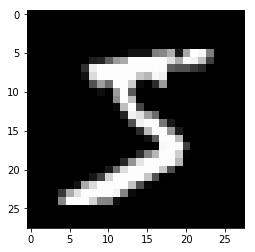

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.show()

PyTorch uses `torch.tensor`, rather than numpy arrays, so we need to convert our data.

In [51]:
import torch

x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

## Neural net from scratch (no torch.nn)

- For the weights, we set `requires_grad` after the initialization, since we don't want that step included in the gradient. (Note that a trailling `_` in PyTorch signifies that the operation is performed in-place.)
- NB: We are initializing the weights here with `Xavier initialisation` (by multiplying with `1/sqrt(n)`).

In [61]:
import math

weights = torch.randn(784,10)/math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [10]:
def log_softmax(x): return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb): return log_softmax(xb @ weights + bias)

In [20]:
bs = 64

xb = x_train[: bs]
preds = model(xb)
preds[0], preds.shape

(tensor([-2.7307, -1.9816, -2.2988, -2.3469, -2.5004, -2.0978, -2.5529, -2.4600,
         -1.9636, -2.3802], grad_fn=<SelectBackward>), torch.Size([64, 10]))

As you see, the `preds` tensor contains not only the tensor values, but also a gradient function. We'll use this later to do backprop.

negative log-likelihood to use as the loss function

In [27]:
def nll(inp, target): return -inp[range(target.shape[0]), target].mean()
loss_fn = nll

In [28]:
yb = y_train[: bs]
loss_fn(preds, yb)

tensor(2.2690, grad_fn=<NegBackward>)

In [29]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [30]:
accuracy(preds, yb)

tensor(0.1562)

We can now run a training loop. For each iteration, we will:
- select a mini-batch of data (of size bs)
- use the model to make predictions
- calculate the loss
- `loss.backward()` updates the gradients of the model, in this case, weights and bias.
- We now use these gradients to update the weights and bias. We do this within the `torch.no_grad()` context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch's Autograd records operations here.
- We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. `loss.backward()` adds the gradients to whatever is already stored, rather than replacing them).

In [54]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 10

In [62]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        acc = accuracy(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            weights -= lr * weights.grad
            bias -= lr * bias.grad
            weights.grad.zero_()
            bias.grad.zero_()
            
    print(f"Epoch: {epoch+1} - loss: {loss:.4f} - accuracy: {acc:.4f}")

Epoch: 1 - loss: 0.4097 - accuracy: 0.9375
Epoch: 2 - loss: 0.3201 - accuracy: 0.9375
Epoch: 3 - loss: 0.2749 - accuracy: 0.9375
Epoch: 4 - loss: 0.2451 - accuracy: 0.9375
Epoch: 5 - loss: 0.2235 - accuracy: 0.9375
Epoch: 6 - loss: 0.2071 - accuracy: 0.9375
Epoch: 7 - loss: 0.1943 - accuracy: 0.9375
Epoch: 8 - loss: 0.1841 - accuracy: 0.9375
Epoch: 9 - loss: 0.1759 - accuracy: 0.9375
Epoch: 10 - loss: 0.1692 - accuracy: 0.9375


In [46]:
xb = x_valid[: bs]
yb = y_valid[: bs]

loss_fn(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2742, grad_fn=<NegBackward>), tensor(0.9531))

In [63]:
torch.argmax(model(xb), dim=1)

tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8])

In [64]:
yb

tensor([9, 3, 7, 0, 9, 0, 8, 5, 5, 2, 4, 5, 0, 8, 4, 8])

## Using torch.nn.functional
- we'll start taking advantage of PyTorch's nn classes to make it more concise and flexible
- The first and easiest step is to make our code shorter by replacing our hand-written activation and loss functions with those from `torch.nn.functional`(which is generally imported into the namespace F by convention)
- This module contains all the functions in the torch.nn library (whereas other parts of the library contain classes)
- Pytorch provides a single function `F.cross_entropy` that combines `log likelihood loss` and `log softmax` activation

In [81]:
import torch.nn.functional as F

loss_fn = F.cross_entropy

def model(xb): return xb @ weights + bias

In [67]:
loss_fn(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0557, grad_fn=<NllLossBackward>), tensor(1.))

## Refactor using nn.Module
- Next up, we'll use `nn.Module` and `nn.Parameter`, for a clearer and more concise training loop
- We subclass `nn.Module` (which itself is a class and able to keep track of state) to holds our `weights`, `bias`, and method for the `forward step`.

In [69]:
from torch import nn

class Mnist_logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [70]:
model = Mnist_logistic()

Note that `nn.Module` objects are used as if they are functions (i.e they are callable), but behind the scenes Pytorch will call our forward method automatically.

In [71]:
loss_fn(model(xb), yb)

tensor(2.3817, grad_fn=<NllLossBackward>)

In [77]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1)//bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i: end_i]
            yb = y_train[start_i: end_i]
            pred = model(xb)
            loss = loss_fn(pred, yb)
            acc = accuracy(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= lr * p.grad
                model.zero_grad()
        print(f"Epoch: {epoch+1} - loss: {loss:.4f} - accuracy: {acc:.4f}") 

In [78]:
fit()

Epoch: 1 - loss: 0.1595 - accuracy: 0.9375
Epoch: 2 - loss: 0.1552 - accuracy: 0.9375
Epoch: 3 - loss: 0.1516 - accuracy: 0.9375
Epoch: 4 - loss: 0.1484 - accuracy: 0.9375
Epoch: 5 - loss: 0.1457 - accuracy: 0.9375
Epoch: 6 - loss: 0.1432 - accuracy: 0.9375
Epoch: 7 - loss: 0.1410 - accuracy: 0.9375
Epoch: 8 - loss: 0.1391 - accuracy: 0.9375
Epoch: 9 - loss: 0.1373 - accuracy: 0.9375
Epoch: 10 - loss: 0.1356 - accuracy: 0.9375


## Refactor using nn.Linear
- Instead of manually defining and initializing `self.weights` and `self.bias`, and calculating `xb  @ self.weights + self.bias`, we will instead use the Pytorch class `nn.Linear` for a linear layer, which does all that for us
- Pytorch has many types of `predefined layers` that can `greatly simplify our code`, and often makes it `faster too`.

In [83]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)

In [84]:
model = Mnist_Logistic()
loss_fn(model(xb), yb)

tensor(2.2884, grad_fn=<NllLossBackward>)

In [85]:
fit()

Epoch: 1 - loss: 0.4044 - accuracy: 0.9375
Epoch: 2 - loss: 0.3162 - accuracy: 0.9375
Epoch: 3 - loss: 0.2719 - accuracy: 0.9375
Epoch: 4 - loss: 0.2427 - accuracy: 0.9375
Epoch: 5 - loss: 0.2215 - accuracy: 0.9375
Epoch: 6 - loss: 0.2055 - accuracy: 0.9375
Epoch: 7 - loss: 0.1929 - accuracy: 0.9375
Epoch: 8 - loss: 0.1830 - accuracy: 0.9375
Epoch: 9 - loss: 0.1750 - accuracy: 0.9375
Epoch: 10 - loss: 0.1684 - accuracy: 0.9375


## Refactor using optim
- Pytorch also has a package with various optimization algorithms, `torch.optim`
- We can use the step method from our optimizer to take a forward step, instead of manually updating each parameter.

In [86]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

In [88]:
model, opt = get_model()
loss_fn(model(xb), yb)

tensor(2.2495, grad_fn=<NllLossBackward>)

In [89]:
for epoch in range(epochs): 
    for i in range((n-1)//bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        acc = accuracy(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    print(f"Epoch: {epoch+1} - loss: {loss:.4f} - accuracy: {acc:.4f}")        

Epoch: 1 - loss: 0.4006 - accuracy: 0.9375
Epoch: 2 - loss: 0.3129 - accuracy: 0.9375
Epoch: 3 - loss: 0.2688 - accuracy: 0.9375
Epoch: 4 - loss: 0.2399 - accuracy: 0.9375
Epoch: 5 - loss: 0.2189 - accuracy: 0.9375
Epoch: 6 - loss: 0.2030 - accuracy: 0.9375
Epoch: 7 - loss: 0.1906 - accuracy: 0.9375
Epoch: 8 - loss: 0.1809 - accuracy: 0.9375
Epoch: 9 - loss: 0.1730 - accuracy: 0.9375
Epoch: 10 - loss: 0.1666 - accuracy: 0.9375


## Refactor using Dataset
- PyTorch has an abstract Dataset class
- A Dataset can be anything that has a `__len__` function (called by Python's standard len function) and a `__getitem__` function as a way of indexing into it.
- PyTorch's TensorDataset is a Dataset wrapping tensors.
- We can iterate, index, and slice along the first dimension of a tensor.
- This will make it easier to access both the independent and dependent variables in the same line as we train.

In [90]:
from torch.utils.data import TensorDataset

# Both x_train and y_train can be combined in a single TensorDataset, 
# which will be easier to iterate over and slice.
train_ds = TensorDataset(x_train, y_train)

In [91]:
model, opt = get_model()

In [92]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        xb, yb = train_ds[i*bs: i*bs+bs]
        pred = model(xb)
        loss = loss_fn(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
    print(f"Epoch: {epoch+1} - loss: {loss:.4f} - accuracy: {acc:.4f}")        

Epoch: 1 - loss: 0.3927 - accuracy: 0.9375
Epoch: 2 - loss: 0.3070 - accuracy: 0.9375
Epoch: 3 - loss: 0.2641 - accuracy: 0.9375
Epoch: 4 - loss: 0.2359 - accuracy: 0.9375
Epoch: 5 - loss: 0.2155 - accuracy: 0.9375
Epoch: 6 - loss: 0.2001 - accuracy: 0.9375
Epoch: 7 - loss: 0.1882 - accuracy: 0.9375
Epoch: 8 - loss: 0.1787 - accuracy: 0.9375
Epoch: 9 - loss: 0.1711 - accuracy: 0.9375
Epoch: 10 - loss: 0.1650 - accuracy: 0.9375


## Refactor using DataLoader
- Pytorch's DataLoader is responsible for managing batches
- DataLoader makes it easier to iterate over batches
- Rather than having to use `train_ds[i*bs : i*bs+bs]`, the DataLoader gives us each `minibatch automatically`.

In [93]:
from torch.utils.data import DataLoader

In [94]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

In [95]:
for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    print(f"Epoch: {epoch+1} - loss: {loss:.4f} - accuracy: {acc:.4f}")     

Epoch: 1 - loss: 0.1598 - accuracy: 0.9375
Epoch: 2 - loss: 0.1555 - accuracy: 0.9375
Epoch: 3 - loss: 0.1518 - accuracy: 0.9375
Epoch: 4 - loss: 0.1487 - accuracy: 0.9375
Epoch: 5 - loss: 0.1459 - accuracy: 0.9375
Epoch: 6 - loss: 0.1434 - accuracy: 0.9375
Epoch: 7 - loss: 0.1413 - accuracy: 0.9375
Epoch: 8 - loss: 0.1393 - accuracy: 0.9375
Epoch: 9 - loss: 0.1375 - accuracy: 0.9375
Epoch: 10 - loss: 0.1359 - accuracy: 0.9375
